# Nota Importante
O propósito deste notebook é retreinar o melhor modelo, que foi encontrado na etapa 4, com os melhores hiperparâmetros definidos para todas as transformações e criação de features.

Na etapa 6, até encontramos uma versão levemente melhor usando Ridge, mas não vale a pena, considerando o aumento da complexidade do modelo.

Após essa etapa, nosso modelo estará pronto para ser usado em produção.

---

Leia o arquivo [README.md](../README.md) para detalhes sobre a base o projeto.

Leia o arquivo de [01_dicionario_de_dados.md](../referencias/01_dicionario_de_dados.md) para detalhes sobre a base.

Ao importar esse arquivo [src.graficos](./src/graficos.py), em tema seaborn é aplicado.

# Imports e configurações

In [1]:
from joblib import dump
import matplotlib.pyplot as plt
import pandas as pd
# from pprint import pprint
import seaborn as sns
import warnings


from sklearn.compose import ColumnTransformer # constrói um pipeline para diferentes colunas
from sklearn.linear_model import (
    # ElasticNet, # uma combinação de Lasso e Ridge para regularização de features
    # Lasso, # regularização é dada pela norma l1
    LinearRegression, # modelo de regressão linear com coeficientes estimados usando o método dos mínimos quadrados
    # Ridge, # regularização é dada pela norma l2
)
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline # enfileira diferentes procedimentos
from sklearn.preprocessing import (  # Módulo de pré-processamento de dados
    OneHotEncoder,       # Codifica variáveis categóricas nominais, transformando-as em uma matriz binária (uma coluna para cada categoria)
    OrdinalEncoder,      # Codifica variáveis categóricas ordinais, convertendo categorias em inteiros com base na ordem
    PolynomialFeatures,  # Cria features polinomiais e de multiplicação entre elas.
    PowerTransformer,    # Aplica uma transformação de potência para estabilizar a variância e tornar os dados mais gaussianos
    QuantileTransformer, # Realiza uma transformação baseada em quantis, escalando os dados para uma distribuição uniforme ou normal
    StandardScaler,      # Normaliza os dados para que tenham média zero e desvio padrão um, útil para dados normalmente distribuídos
)

from src.auxiliares import (
    fnc_dataframe_coeficientes, # função que combina os coeficientes de um gridsearch com os nomes das features em um DataFrame
    fnc_describe_numericas_personalizado, # função que retorna um dataframe com o describe() de variáveis numéricas enriquecido com colunas de tipo, ausência, variabilidade, outliers e normalidade
)
from src.config import (
    DADOS_X_TEST,
    DADOS_X_TRAIN,
    DADOS_X_VALIDATION,
    DADOS_Y_TEST,
    DADOS_Y_TRAIN,
    DADOS_Y_VALIDATION,
    MODELO_FINAL,
)
from src.graficos import (
    PALETTE_TEMPERATURA,
    plot_coeficientes, # função para plotar um gráfico de barras horizontais dos coeficientes de um modelo
    plot_residuos_estimador, # função que plota 3 gráficos de resíduos para um estimador, um histograma e dois de dispersão
)
from src.models import (
    fnc_construir_pipeline_modelo_regressao, # função que retorna um pipeline de modelo pronto para treinamento
    fnc_treinar_e_validar_um_modelo_regressao, # função para treinar um único modelo de regressão e avaliar o desempenho.
)

In [2]:
pd.options.display.max_rows = 15
pd.options.display.max_columns = None
pd.options.display.float_format = '{:.2f}'.format

# Ignorar UserWarnings
warnings.filterwarnings('ignore', category=UserWarning)


## Carregando os dados sem outliers para retreino do modelo

Origem: [01-ild-eda.ipynb](01-ild-eda.ipynb)

- `median_income`: renda mediana no grupo de blocos (em dezenas de milhares de dólares)
- `housing_median_age`: idade mediana das casas no grupo de blocos
- `total_rooms`: número cômodos no grupo de blocos
- `total_bedrooms`: número de quartos no grupo de blocos
- `population`: população do grupo de blocos
- `households`: domicílios no grupo de blocos
- `latitude`: latitude do grupo de blocos
- `longitude`: longitude do grupo de blocos
- `ocean_proximity`: proximidade do oceano
  - `NEAR BAY`: perto da baía
  - `<1H OCEAN`: a menos de uma hora do oceano
  - `INLAND`: no interior
  - `NEAR OCEAN`: perto do oceano
- `median_house_value`: valor mediano das casas no grupo de blocos (em dólares)
- `median_income_cat`: categorias baseadas no valor da mediana do salário anual -> `median_income`
- `housing_median_age_cat`: categorias baseadas no valor da mediana das idades das casas -> `housing_median_age`
- `population_cat`: categorias baseadas no tamanho da população -> `population`
- `rooms_per_household`: `total_rooms` / `households`
- `population_per_household`: `population` / `households`
- `bedrooms_per_room`: `total_bedrooms` / `total_rooms`

In [3]:
# dados já separados como X e y de treino, teste e validação
X_train = pd.read_parquet(DADOS_X_TRAIN)
y_train = pd.read_parquet(DADOS_Y_TRAIN)
X_test = pd.read_parquet(DADOS_X_TEST)
y_test = pd.read_parquet(DADOS_Y_TEST)
y_validation = pd.read_parquet(DADOS_Y_VALIDATION)
X_validation = pd.read_parquet(DADOS_X_VALIDATION)

print('X_train.shape', X_train.shape)
print('y_train.shape', y_train.shape)
print('X_test.shape', X_test.shape)
print('y_test.shape', y_test.shape)
print('X_validation.shape', X_validation.shape)
print('y_validation.shape', y_validation.shape)


X_train.shape (12862, 15)
y_train.shape (12862, 1)
X_test.shape (3639, 15)
y_test.shape (3639, 1)
X_validation.shape (1874, 15)
y_validation.shape (1874, 1)


In [4]:
display(
    X_train.head(1),
    y_train.head(1),
    X_test.head(1),
    y_test.head(1),
    X_validation.head(1),
    y_validation.head(1),
)

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,ocean_proximity,median_income_cat,housing_median_age_cat,population_cat,rooms_per_household,population_per_household,bedrooms_per_room
4816,-118.28,33.91,41,620,133,642,162,2.65,<1H OCEAN,1.5 <= x < 3,40 <= x,500 <= x < 1000,3.83,3.96,0.21


,median_house_value
4816,159600


,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,ocean_proximity,median_income_cat,housing_median_age_cat,population_cat,rooms_per_household,population_per_household,bedrooms_per_room
13191,-117.19,32.77,9,634,152,248,133,3.86,NEAR OCEAN,3 <= x < 4.5,0 <= x < 10,0 <= x < 500,4.77,1.86,0.24


,median_house_value
13191,143800


,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,ocean_proximity,median_income_cat,housing_median_age_cat,population_cat,rooms_per_household,population_per_household,bedrooms_per_room
15596,-121.95,37.26,10,3611,803,1599,716,5.20,<1H OCEAN,4.5 <= x < 6,10 <= x < 20,1500 <= x < 2000,5.04,2.23,0.22


,median_house_value
15596,248700


# Estratégia para retreino do modelo vencedor da etapa 4

## Definindo a estratégia para o modelo

In [5]:
coluna_target = ['median_house_value']

# define as colunas a serem transformadas 
colunas_one_hot_encoder = ['ocean_proximity',]
colunas_ordinal_encoder = ['median_income_cat', 'housing_median_age_cat', 'population_cat',]
colunas_standard_scaler_poly = ['longitude', 'latitude', 'housing_median_age']
colunas_power_tranformer_poly = X_train.columns.difference( # colunas restantes com outliers
    colunas_one_hot_encoder + colunas_ordinal_encoder + colunas_standard_scaler_poly
).to_list()


# enfileira uma transformação depois de outra
pipeline_standard_poly = Pipeline(
    steps=(
        ('standard_scaler', StandardScaler()),
        ('poly', PolynomialFeatures(degree=3, interaction_only=False, include_bias=False)),
    ),
)

# enfileira uma transformação depois de outra
pipeline_power_poly = Pipeline(
    steps=(
        ('power_transformer', PowerTransformer(method='box-cox')), # box-cox só funciona para números positivos
        ('poly', PolynomialFeatures(degree=3, interaction_only=True, include_bias=False)),
    ),
)


# define o preprocessamento das colunas - o preprocessamento é feito em ordem
preprocessor = ColumnTransformer(
    transformers=[
        ('one_hot_encoder', OneHotEncoder(drop='first'), colunas_one_hot_encoder), # drop='first' para evitar a dummy variable trap
        ('ordinal_encoder', OrdinalEncoder(categories='auto'), colunas_ordinal_encoder), # categories='auto' para usar as categorias do dataframe
        ('standard_scaler_poly', pipeline_standard_poly, colunas_standard_scaler_poly),
        ('power_transformer_poly', pipeline_power_poly, colunas_power_tranformer_poly),
    ],
)



target_transfomer = QuantileTransformer(output_distribution='normal')

## Construindo e treinando o modelo de acordo com a estratégia definida acima


In [6]:
# construindo o modelo com a melhor estratégia e hiperparâmetros
modelo = fnc_construir_pipeline_modelo_regressao(
    preprocessor=preprocessor,
    regressor=LinearRegression(),
    target_transformer=target_transfomer
)

display(modelo)
# pprint(modelo.get_params)

TransformedTargetRegressor(regressor=Pipeline(steps=[('preprocessor',
                                                      ColumnTransformer(transformers=[('one_hot_encoder',
                                                                                       OneHotEncoder(drop='first'),
                                                                                       ['ocean_proximity']),
                                                                                      ('ordinal_encoder',
                                                                                       OrdinalEncoder(),
                                                                                       ['median_income_cat',
                                                                                        'housing_median_age_cat',
                                                                                        'population_cat']),
                                                                                      ('standard_scaler_poly',
                                                                                       Pipeline(steps=(('standard_scaler',
                                                                                                        StandardScaler()),
                                                                                                       ('p...
                                                                                                        PowerTransformer(method='box-cox')),
                                                                                                       ('poly',
                                                                                                        PolynomialFeatures(degree=3,
                                                                                                                           include_bias=False,
                                                                                                                           interaction_only=True)))),
                                                                                       ['bedrooms_per_room',
                                                                                        'households',
                                                                                        'median_income',
                                                                                        'population',
                                                                                        'population_per_household',
                                                                                        'rooms_per_household',
                                                                                        'total_bedrooms',
                                                                                        'total_rooms'])])),
                                                     ('regressor',
                                                      LinearRegression())]),
                           transformer=QuantileTransformer(output_distribution='normal'))

In [7]:
metricas_avaliar = ( # metrícas a avaliar
        'adjusted_r2_score',              # R² ajustado
        # 'd2_absolute_error_score',        # D² regression score function, fraction of absolute error explained.
        # 'd2_pinball_score',               # D² regression score function, fraction of pinball loss explained.
        # 'd2_tweedie_score',               # D² regression score function, fraction of Tweedie deviance explained.
        # 'explained_variance_score',       # Explained variance regression score function.
        # 'max_error',                      # The max_error metric calculates the maximum residual error.
        'mean_absolute_error',            # Mean absolute error regression loss.
        'mean_absolute_percentage_error', # Mean absolute percentage error (MAPE) regression loss.
        # 'mean_gamma_deviance',            # Mean Gamma deviance regression loss.
        # 'mean_pinball_loss',              # Pinball loss for quantile regression.
        # 'mean_poisson_deviance',          # Mean Poisson deviance regression loss.
        # 'mean_squared_error',             # Mean squared error regression loss.
        # 'mean_squared_log_error',         # Mean squared logarithmic error regression loss.
        # 'mean_tweedie_deviance',          # Mean Tweedie deviance regression loss.
        # 'median_absolute_error',          # Median absolute error regression loss.
        'r2_score',                       # R² (coefficient of determination) regression score function.
        'root_mean_squared_error',        # Root mean squared error regression loss.
        # 'root_mean_squared_log_error',    # Root mean squared logarithmic error regression loss.
    )

resultados = fnc_treinar_e_validar_um_modelo_regressao(
    modelo=modelo,
    X_train = X_train,
    y_train = y_train,
    X_test = X_test,
    y_test = y_test,
    X_validation = X_validation,
    y_validation = y_validation,
    metricas = metricas_avaliar,
)

# display(modelo)
display(resultados.style.background_gradient(cmap=PALETTE_TEMPERATURA, axis='columns'))

,Treino,Teste,Validação
adjusted_r2_score,0.714143,0.691645,0.680420
mean_absolute_error,36022.910635,36758.628405,37680.243448
mean_absolute_percentage_error,0.208390,0.219363,0.220309
r2_score,0.714477,0.692916,0.682979
root_mean_squared_error,51120.834462,52719.944659,54757.153734


### Sobre o melhor modelo retreinado
- Treino teve `RMSE` melhor que o encontrado anteriomente com o GRID SEARCH na etapa 4.
- Naturalmente, Teste e Validação, nessa ordem, foram perdendo desempenho, o que é normal, considerando que não foram usadas para treinamento em qualquer momento.
- As demais métricas mostraram o mesm comportamento, lembando que `R²` é melhor quando maior e os demais são melhores quando menores.

## Avaliando o modelo criado

In [8]:
# se esse numero for muito grande, melhor apresentar num dataframe vertical
# por causa das configurações de pandas feitas no inicio
len(modelo.regressor_['regressor'].coef_)

117

117 é variável demais para visualizar, vamos ver apenas as primeiras mais relevantes para o modelo.

In [9]:
df_coeficientes = fnc_dataframe_coeficientes(
    colunas      = modelo.regressor_['preprocessor'].get_feature_names_out(),
    coeficientes = modelo.regressor_['regressor'].coef_,
    flg_mostrar_dataframe=False,
    flg_horizontal=False,
)
df_coeficientes.head()

,coeficiente
power_transformer_poly__population total_rooms,-199.54
power_transformer_poly__population total_bedrooms,186.44
power_transformer_poly__households total_bedrooms,-178.16
power_transformer_poly__households total_rooms,159.70
power_transformer_poly__bedrooms_per_room households,63.19


In [10]:
df_coeficientes.tail().style.format(precision=10)

,coeficiente
ordinal_encoder__housing_median_age_cat,0.0136713568
ordinal_encoder__median_income_cat,-0.0080239109
power_transformer_poly__median_income total_bedrooms total_rooms,-0.0027415270
ordinal_encoder__population_cat,-0.0026981806
standard_scaler_poly__housing_median_age^3,0.0011020391


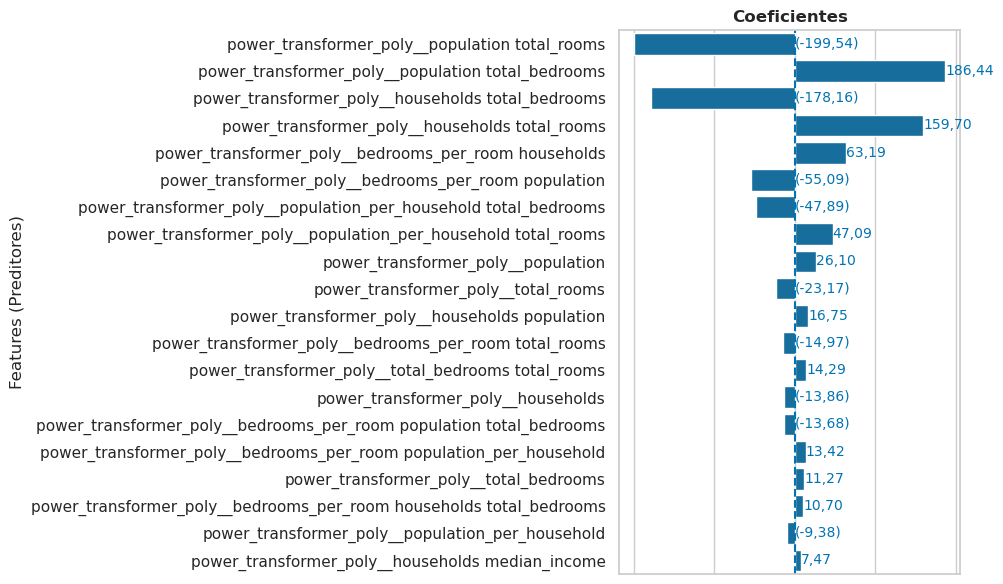

In [11]:
plot_coeficientes(df_coeficientes, precisao=2,)

Compararando com a etapa 4, podemos ver que a transformação das variáveis foi capaz de repetir a ordem e as colunas, com uma leve variação nos valores dos coeficientes.

## Resíduos do modelo

### Resíduos sobre a base de treino

In [12]:
df_residuos = pd.DataFrame()
df_residuos['residuos'] = y_train - modelo.predict(X_train)

df_describe = fnc_describe_numericas_personalizado(
    df=df_residuos,
    flg_mostrar_dataframe=False,
    flg_retornar_dataframe=True,
    teste_normalidade='Kolmogorov-Smirnov'
)

df_describe[['dist_normal', 'pvalue', 'teste_normalidade', 'skewness', 'kurtosis',]].T

/dados/app/conda/envs/california/lib/python3.12/site-packages/pandas/core/dtypes/cast.py:377: RuntimeWarning: invalid value encountered in cast
  new_result = trans(result).astype(dtype)


,residuos
dist_normal,False
pvalue,0
teste_normalidade,Kolmogorov-Smirnov
skewness,1.05
kurtosis,3.54


,min,LOWER,01%,25%,50%,75%,99%,UPPER,max,mean,std
residuos,-206923.369923,-103172.408753,-105275.291410,-25600.613281,-2055.710449,26113.916764,175000.206615,103685.712075,348247.012176,3797.643799,50981.562500


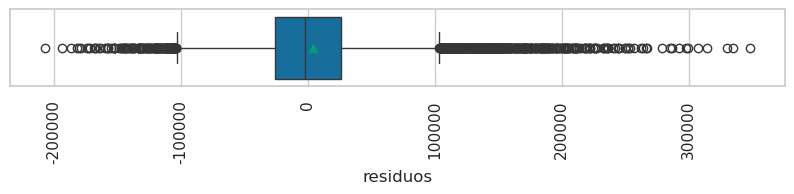

In [13]:
display(
    df_describe[['min', 'LOWER', '01%', '25%', '50%', '75%', '99%', 'UPPER', 'max', 'mean', 'std',
    ]].style.background_gradient(
        cmap=PALETTE_TEMPERATURA,
        axis='columns',
        subset=['min', 'LOWER', '01%', '25%', '50%', '75%', '99%', 'UPPER', 'max', 'mean',]
    )
)

# boxplot
fig, ax = plt.subplots(figsize=(10, 1))
sns.boxplot(
    data=df_residuos,
    x='residuos',
    showmeans=True,
    ax=ax,
)
# Definindo a orientação dos tick labels do eixo x na vertical
ax.set_xticklabels(
    labels=[int(x) for x in ax.get_xticks()],
    rotation=90,
)
plt.show()

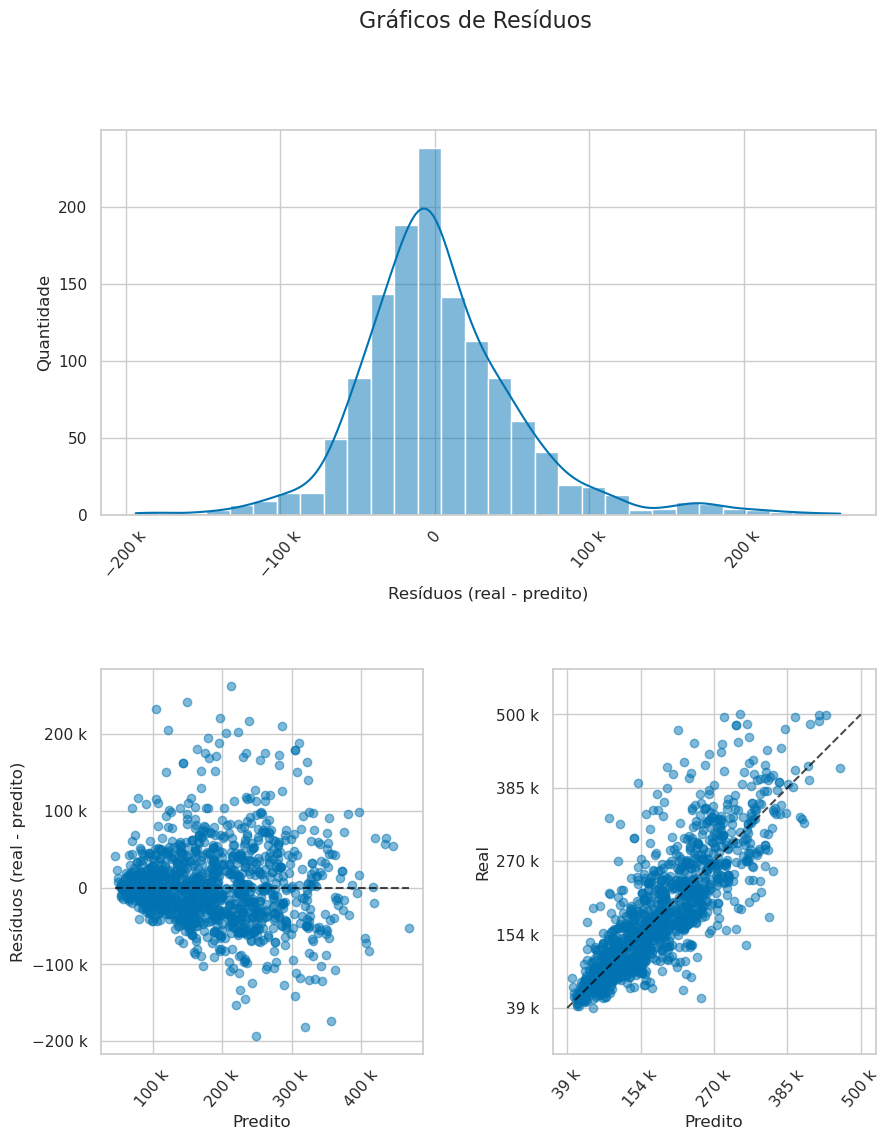

In [14]:
plot_residuos_estimador(modelo, X_train, y_train, fracao_amostra=0.1, eng_formatter=True)

### Resíduos sobre a base de teste
Essa base não participou do treinamento em nenhum momento e são novos para o modelo.

In [15]:
df_residuos = pd.DataFrame()
df_residuos['residuos'] = y_test - modelo.predict(X_test)

df_describe = fnc_describe_numericas_personalizado(
    df=df_residuos,
    flg_mostrar_dataframe=False,
    flg_retornar_dataframe=True,
    teste_normalidade='Kolmogorov-Smirnov'
)

df_describe[['dist_normal', 'pvalue', 'teste_normalidade', 'skewness', 'kurtosis',]].T

/dados/app/conda/envs/california/lib/python3.12/site-packages/pandas/core/dtypes/cast.py:377: RuntimeWarning: invalid value encountered in cast
  new_result = trans(result).astype(dtype)


,residuos
dist_normal,False
pvalue,0
teste_normalidade,Kolmogorov-Smirnov
skewness,0.70
kurtosis,3.78


,min,LOWER,01%,25%,50%,75%,99%,UPPER,max,mean,std
residuos,-328810.981169,-103718.587779,-124650.151712,-26116.732422,-3450.497803,25617.838632,171430.901433,103219.694478,324597.957130,2744.314453,52655.704550


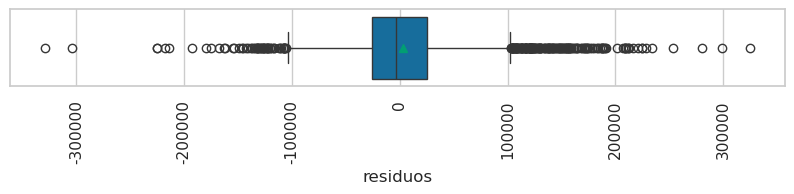

In [16]:
display(
    df_describe[['min', 'LOWER', '01%', '25%', '50%', '75%', '99%', 'UPPER', 'max', 'mean', 'std',
    ]].style.background_gradient(
        cmap=PALETTE_TEMPERATURA,
        axis='columns',
        subset=['min', 'LOWER', '01%', '25%', '50%', '75%', '99%', 'UPPER', 'max', 'mean',]
    )
)

# boxplot
fig, ax = plt.subplots(figsize=(10, 1))
sns.boxplot(
    data=df_residuos,
    x='residuos',
    showmeans=True,
    ax=ax,
)
# Definindo a orientação dos tick labels do eixo x na vertical
ax.set_xticklabels(
    labels=[int(x) for x in ax.get_xticks()],
    rotation=90,
)
plt.show()

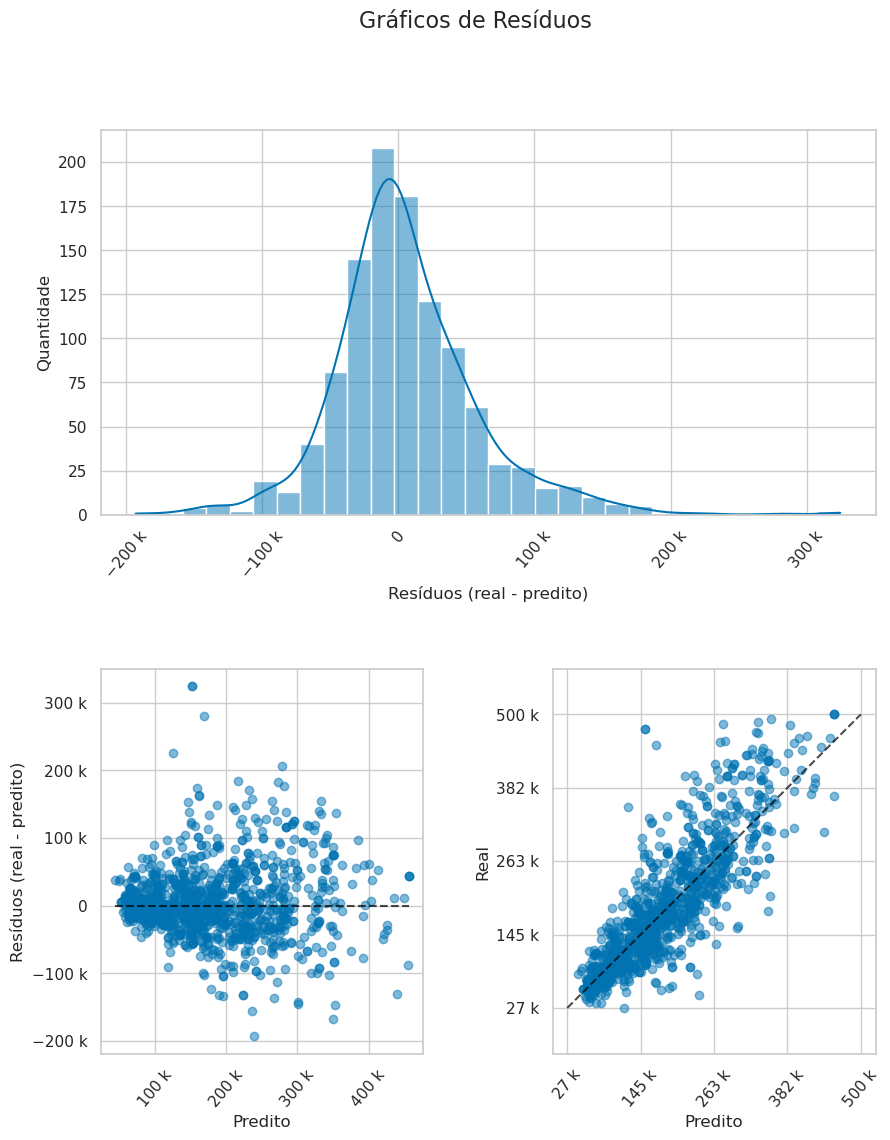

In [17]:
plot_residuos_estimador(modelo, X_test, y_test, fracao_amostra=0.3, eng_formatter=True)

### Resíduos sobre a base de validação
Essa base não participou do treinamento em nenhum momento e são novos para o modelo.

In [18]:
df_residuos = pd.DataFrame()
df_residuos['residuos'] = y_validation - modelo.predict(X_validation)

df_describe = fnc_describe_numericas_personalizado(
    df=df_residuos,
    flg_mostrar_dataframe=False,
    flg_retornar_dataframe=True,
    teste_normalidade='Kolmogorov-Smirnov'
)

df_describe[['dist_normal', 'pvalue', 'teste_normalidade', 'skewness', 'kurtosis',]].T

/dados/app/conda/envs/california/lib/python3.12/site-packages/pandas/core/dtypes/cast.py:377: RuntimeWarning: invalid value encountered in cast
  new_result = trans(result).astype(dtype)


,residuos
dist_normal,False
pvalue,0
teste_normalidade,Kolmogorov-Smirnov
skewness,0.98
kurtosis,4.75


,min,LOWER,01%,25%,50%,75%,99%,UPPER,max,mean,std
residuos,-313455.572528,-102958.794999,-120298.115145,-25842.679688,-2104.558105,25568.064453,189895.957078,102684.179688,355908.777571,3446.378906,54663.175781


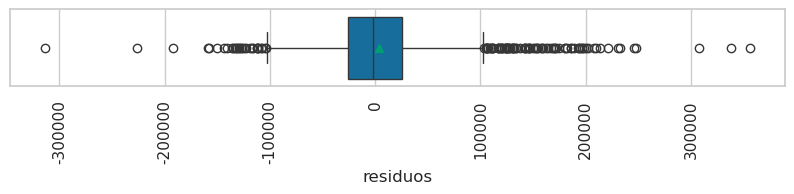

In [19]:
display(
    df_describe[['min', 'LOWER', '01%', '25%', '50%', '75%', '99%', 'UPPER', 'max', 'mean', 'std',
    ]].style.background_gradient(
        cmap=PALETTE_TEMPERATURA,
        axis='columns',
        subset=['min', 'LOWER', '01%', '25%', '50%', '75%', '99%', 'UPPER', 'max', 'mean',]
    )
)

# boxplot
fig, ax = plt.subplots(figsize=(10, 1))
sns.boxplot(
    data=df_residuos,
    x='residuos',
    showmeans=True,
    ax=ax,
)
# Definindo a orientação dos tick labels do eixo x na vertical
ax.set_xticklabels(
    labels=[int(x) for x in ax.get_xticks()],
    rotation=90,
)
plt.show()

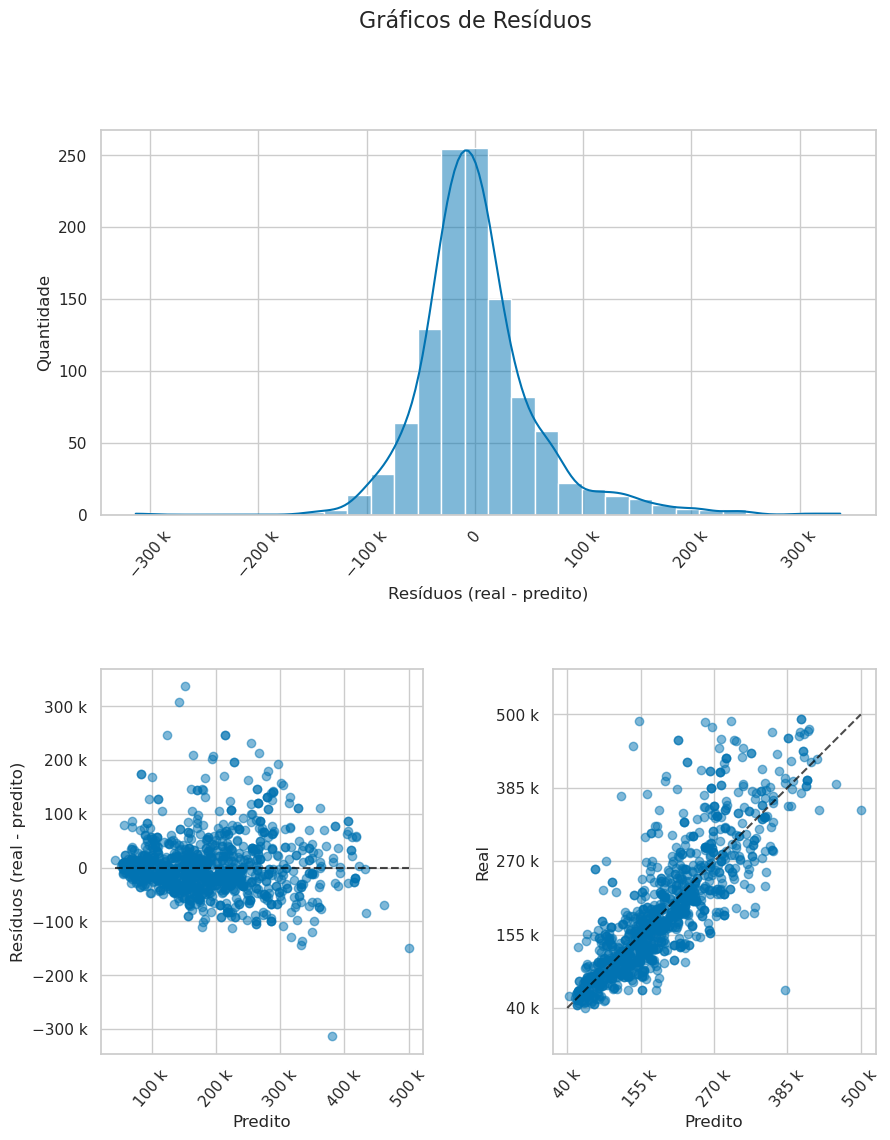

In [20]:
plot_residuos_estimador(modelo, X_validation, y_validation, fracao_amostra=0.6, eng_formatter=True)

### Analisando os dados e gráficos de resíduos
- O skewness ficou menor em teste e validação que no treino, reduzindo a calda a direita do histograma de resíduos.
- A curtose ficou maior em teste e validação que no treino, mostrando que os erros se concentraram um pouco mais em torno do zero, apesar da marca de outliers aumentar levemente em teste e validação.
- Não podemos notar muita diferença entre os diversos gráficos além das caldas.



Também é importante observar que não temos uma situação de overfitting, pois os dados de teste e validação não participaram do treinamento e ainda assim os resíduos estão próximos que já conhecíamos de etapas anteriores e do próprio treino.

# Salvando o modelo para uso posterior em produção

In [21]:
filenames = dump(
    value=modelo,
    filename=MODELO_FINAL,
    compress=False,
)